In [1]:
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
import h5py
from src.benchmarkers import *
from src.benchmarkersV2 import *
import time
from matplotlib import pyplot as plt
np.random.seed(0)

In [2]:
def is_leaf(name, node):
    """Check if a node is a dataset (leaf)."""
    return isinstance(node, h5py.Dataset)

def find_leaf_datasets(hdf5_file):
    """Find and return paths to all leaf datasets in an HDF5 file."""
    leaf_datasets = []

    # Traverse the HDF5 file
    hdf5_file.visititems(lambda name, node: leaf_datasets.append(name) if is_leaf(name, node) else None)
    
    return leaf_datasets


In [3]:
N = [10,100,200,300,500]
dim = 192
#N = [10]
iterations = 100

In [4]:
generator = Generator()

In [5]:
for item in N:
    generator.create_dataset(item,f"outputs/v2/column_wise_{dim}/ds_{item}",dim)
    generator.create_arrow_file(f"outputs/v2/column_wise_{dim}/ds_{item}")
    generator.create_arrow_stream(f"outputs/v2/column_wise_{dim}/ds_{item}")
    

In [6]:
arrow_file_memory = ClockColumnWise().benchmark_arrow(f"outputs/v2/column_wise_{dim}/ds",N,iterations,dim,memory=True,stream=False)
arrow_stream_memory = ClockColumnWise().benchmark_arrow(f"outputs/v2/column_wise_{dim}/ds",N,iterations,dim,memory=True,stream=True)
arrow_file_no_memory = ClockColumnWise().benchmark_arrow(f"outputs/v2/column_wise_{dim}/ds",N,iterations,dim,memory=False,stream=False)
arrow_stream_no_memory = ClockColumnWise().benchmark_arrow(f"outputs/v2/column_wise_{dim}/ds",N,iterations,dim,memory=False,stream=True)
arrow_parquet = ClockColumnWise().benchmark_parquet(f"outputs/v2/column_wise_{dim}/ds",N,iterations,dim)
hdf5_core = ClockColumnWise().benchmark_hdf5(f"outputs/v2/column_wise_{dim}/ds",N,iterations,hdf5_driver="core")
hdf5_sec2 = ClockColumnWise().benchmark_hdf5(f"outputs/v2/column_wise_{dim}/ds",N,iterations,hdf5_driver="sec2")

100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


In [7]:
t_load_arrow_file_memory = arrow_file_memory.t_load
t_load_arrow_stream_memory = arrow_stream_memory.t_load
t_load_arrow_file_no_memory = arrow_file_no_memory.t_load
t_load_arrow_stream_no_memory = arrow_stream_no_memory.t_load
t_load_arrow_parquet = arrow_parquet.t_load
t_load_hdf5_core = hdf5_core.t_load
t_load_hdf5_sec2 = hdf5_sec2.t_load

t_manipulate_arrow_file_memory = arrow_file_memory.t_manipulate
t_manipulate_arrow_stream_memory = arrow_stream_memory.t_manipulate
t_manipulate_arrow_file_no_memory = arrow_file_no_memory.t_manipulate
t_manipulate_arrow_stream_no_memory = arrow_stream_no_memory.t_manipulate
t_manipulate_arrow_parquet = arrow_parquet.t_manipulate
t_manipulate_hdf5_core = hdf5_core.t_manipulate
t_manipulate_hdf5_sec2 = hdf5_sec2.t_manipulate

In [8]:
np.save("t_load_arrow_file_memory",t_load_arrow_file_memory)
np.save("t_load_arrow_stream_memory",t_load_arrow_stream_memory)
np.save("t_load_arrow_file_no_memory",t_load_arrow_file_no_memory)
np.save("t_load_arrow_stream_no_memory",t_load_arrow_stream_no_memory)
np.save("t_load_arrow_parquet",t_load_arrow_parquet)
np.save("t_load_hdf5_core",t_load_hdf5_core)
np.save("t_load_hdf5_sec2",t_load_hdf5_sec2)

np.save("t_manipulate_arrow_file_memory",t_manipulate_arrow_file_memory)
np.save("t_manipulate_arrow_stream_memory",t_manipulate_arrow_stream_memory)
np.save("t_manipulate_arrow_file_no_memory",t_manipulate_arrow_file_no_memory)
np.save("t_manipulate_arrow_stream_no_memory",t_manipulate_arrow_stream_no_memory)
np.save("t_manipulate_arrow_parquet",t_manipulate_arrow_parquet)
np.save("t_manipulate_hdf5_core",t_manipulate_hdf5_core)
np.save("t_manipulate_hdf5_sec2",t_manipulate_hdf5_sec2)

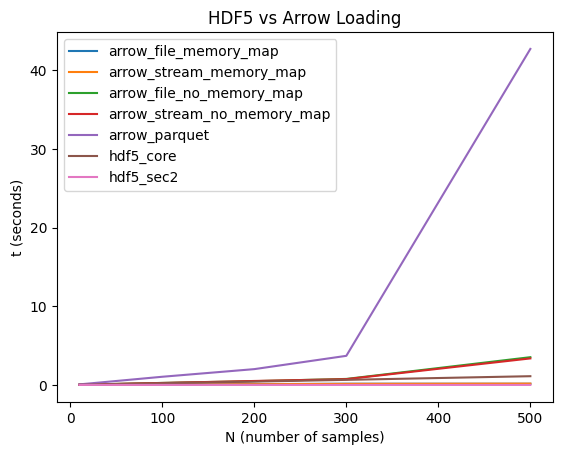

In [9]:
plt.title("HDF5 vs Arrow Loading")
plt.plot(N, t_load_arrow_file_memory, label="arrow_file_memory_map")
plt.plot(N, t_load_arrow_stream_memory, label="arrow_stream_memory_map")
plt.plot(N, t_load_arrow_file_no_memory, label="arrow_file_no_memory_map")
plt.plot(N, t_load_arrow_stream_no_memory, label="arrow_stream_no_memory_map")
plt.plot(N, t_load_arrow_parquet, label="arrow_parquet")
plt.plot(N, t_load_hdf5_core, label="hdf5_core")
plt.plot(N, t_load_hdf5_sec2, label="hdf5_sec2")

# Add a legend
plt.legend()

# Add titles and labels
plt.xlabel("N (number of samples)")
plt.ylabel("t (seconds)")

# Show the plot
plt.savefig(f'load.pdf')  # Save as PDF

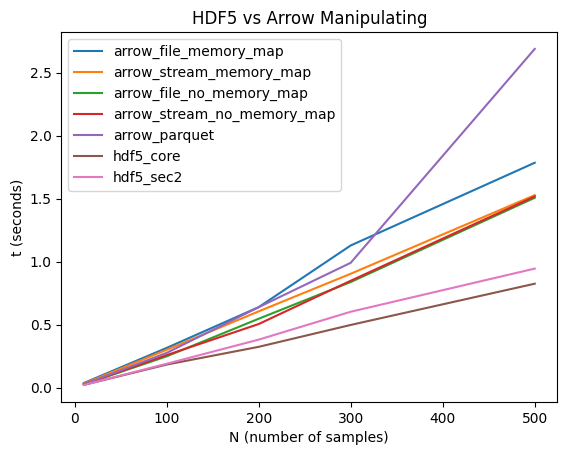

In [10]:
plt.title("HDF5 vs Arrow Manipulating")
plt.plot(N, t_manipulate_arrow_file_memory, label="arrow_file_memory_map")
plt.plot(N, t_manipulate_arrow_stream_memory, label="arrow_stream_memory_map")
plt.plot(N, t_manipulate_arrow_file_no_memory, label="arrow_file_no_memory_map")
plt.plot(N, t_manipulate_arrow_stream_no_memory, label="arrow_stream_no_memory_map")
plt.plot(N, t_manipulate_arrow_parquet, label="arrow_parquet")
plt.plot(N, t_manipulate_hdf5_core, label="hdf5_core")
plt.plot(N, t_manipulate_hdf5_sec2, label="hdf5_sec2")

# Add a legend
plt.legend()

# Add titles and labels
plt.xlabel("N (number of samples)")
plt.ylabel("t (seconds)")

# Show the plot
plt.savefig(f'manipulating.pdf')  # Save as PDF